# classic GCN

In [17]:
import os
import networkx as nx
import torch
import numpy as np
import pandas as pd
import sys
sys.path.append("../codes")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

from model import GCN

In [197]:
def make_x(data):
    for num in range(len(data.y)):
        G = to_networkx(data[num])
        new_x = torch.tensor(
                [[i] for i in list(dict(nx.degree_centrality(G)).values())],
                dtype=torch.float,
            )
        if num == 0:
            x = new_x
        else:
            x = torch.cat([x, new_x])
    return x

In [208]:
# cv_train
def cv_train(loader, model):
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
        if data.x is None:
#             print("n")
            data.x = make_x(data)
        
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

# cv_valid
def cv_test(loader, model):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        if data.x is None:
#             print("n")
            data.x = make_x(data)
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    val_acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    return val_acc

In [209]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fold = KFold(
    n_splits=10, shuffle=True, random_state=0
)

In [217]:
df = pd.DataFrame(columns=["name", "ave_acc", "std_acc"])
cnt = 0
for name in ["COLLAB", "MUTAG", "REDDIT-BINARY", "DD"]:
    print(name)
    dataset = TUDataset(root='data/TUDataset', name=name)
    torch.manual_seed(12345)
    dataset = dataset.shuffle()

    valid_accs = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(dataset, dataset.data.y)):
        train_loader = DataLoader(
            dataset[[i for i in train_idx]],
            shuffle=True,
            batch_size=10,
        )
        valid_loader = DataLoader(
            dataset[[i for i in valid_idx]],
            shuffle=False,
            batch_size=10,
        )

        model = GCN(64, dataset=dataset)
        model.to(device)

        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch_idx in range(10):

            cv_train(train_loader, model)
            valid_acc = cv_test(valid_loader, model)

        print(f"fold {fold_idx} : {valid_acc}")
        valid_accs.append(valid_acc)
    
    print("="*20)
    
    s = pd.Series([name, np.average(valid_accs), np.std(valid_accs)], index=df.columns,name=cnt)
    df = df.append(s)
    cnt += 1



COLLAB
fold 0 : 0.596
fold 1 : 0.594
fold 2 : 0.596
fold 3 : 0.608
fold 4 : 0.6
fold 5 : 0.61
fold 6 : 0.576
fold 7 : 0.582
fold 8 : 0.56
fold 9 : 0.59
MUTAG
fold 0 : 0.7368421052631579
fold 1 : 0.7368421052631579
fold 2 : 0.6842105263157895
fold 3 : 0.8947368421052632
fold 4 : 0.7368421052631579
fold 5 : 0.8947368421052632
fold 6 : 0.7894736842105263
fold 7 : 0.5789473684210527
fold 8 : 0.6666666666666666
fold 9 : 0.6111111111111112
REDDIT-BINARY
fold 0 : 0.76
fold 1 : 0.77
fold 2 : 0.745
fold 3 : 0.74
fold 4 : 0.81
fold 5 : 0.795
fold 6 : 0.76
fold 7 : 0.7
fold 8 : 0.75
fold 9 : 0.78
DD
fold 0 : 0.652542372881356
fold 1 : 0.6864406779661016
fold 2 : 0.7203389830508474
fold 3 : 0.7627118644067796
fold 4 : 0.711864406779661
fold 5 : 0.7457627118644068
fold 6 : 0.6779661016949152
fold 7 : 0.7542372881355932
fold 8 : 0.6923076923076923
fold 9 : 0.7008547008547008


In [218]:
df.to_csv("benchmark_vc_classicGCN.csv")

# DGCNN

In [219]:
import os
import networkx as nx
import torch
import numpy as np
import pandas as pd
import sys
sys.path.append("../codes")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

from DGCNN import DGCNN_Model

In [221]:
# cv_train
def cv_train(loader, model, optimizer, criterion):
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
        if data.x is None:
            data.x = make_x(data)
        data.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

# cv_valid
def cv_test(loader, model,optimizer, criterion):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        if data.x is None:
            data.x = make_x(data)
        data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    val_acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    return val_acc

In [229]:
df = pd.DataFrame(columns=["name", "ave_acc", "std_acc"])
cnt = 0
for name in ["MUTAG", "REDDIT-BINARY", "DD", "COLLAB"]:
    print(name)
    dataset = TUDataset(root='data/TUDataset', name=name)
    torch.manual_seed(12345)
    dataset = dataset.shuffle()

    valid_accs = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(dataset, dataset.data.y)):
        train_loader = DataLoader(
            dataset[[i for i in train_idx]],
            shuffle=True,
            batch_size=10,
        )
        valid_loader = DataLoader(
            dataset[[i for i in valid_idx]],
            shuffle=False,
            batch_size=10,
        )
        if dataset.num_node_features == 0:
            node_feature = 1
        else:
            node_feature = dataset.num_node_features
        model = DGCNN_Model(node_feature, dataset.num_classes)
        model.to(device)

        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch_idx in range(10):

            cv_train(train_loader, model, optimizer, criterion)
            valid_acc = cv_test(valid_loader, model, optimizer, criterion)

        print(f"fold {fold_idx} : {valid_acc}")
        valid_accs.append(valid_acc)
    
    print("="*20)
    
    s = pd.Series([name, np.average(valid_accs), np.std(valid_accs)], index=df.columns,name=cnt)
    df = df.append(s)
    cnt += 1



MUTAG
fold 0 : 0.7894736842105263
fold 1 : 0.8421052631578947
fold 2 : 0.8947368421052632
fold 3 : 0.9473684210526315
fold 4 : 0.8947368421052632
fold 5 : 0.7894736842105263
fold 6 : 0.7894736842105263
fold 7 : 0.7368421052631579
fold 8 : 0.8333333333333334
fold 9 : 0.7222222222222222
REDDIT-BINARY
fold 0 : 0.77
fold 1 : 0.815
fold 2 : 0.835
fold 3 : 0.805
fold 4 : 0.81
fold 5 : 0.845
fold 6 : 0.77
fold 7 : 0.805
fold 8 : 0.76
fold 9 : 0.845
DD
fold 0 : 0.7627118644067796
fold 1 : 0.7627118644067796
fold 2 : 0.7372881355932204
fold 3 : 0.8050847457627118
fold 4 : 0.7288135593220338
fold 5 : 0.7203389830508474
fold 6 : 0.6779661016949152
fold 7 : 0.7457627118644068
fold 8 : 0.7777777777777778
fold 9 : 0.7692307692307693
COLLAB
fold 0 : 0.652
fold 1 : 0.704
fold 2 : 0.69
fold 3 : 0.69
fold 4 : 0.65
fold 5 : 0.648
fold 6 : 0.634
fold 7 : 0.644
fold 8 : 0.638
fold 9 : 0.654


In [230]:
df.to_csv("benchmark_cv_DGCNN.csv")

MUTAG
num dataset : 188
num class : 2
max nodes : 28
average nodes : 17.930851063829788
std nodes : 4.575664737098715
REDDIT-BINARY
num dataset : 2000
num class : 2
max nodes : 3782
average nodes : 429.627
std nodes : 554.0582305777978
DD
num dataset : 1178
num class : 2
max nodes : 5748
average nodes : 284.3166383701188
std nodes : 271.99968930043167
COLLAB
num dataset : 5000
num class : 3
max nodes : 492
average nodes : 74.4948
std nodes : 62.30084086880369


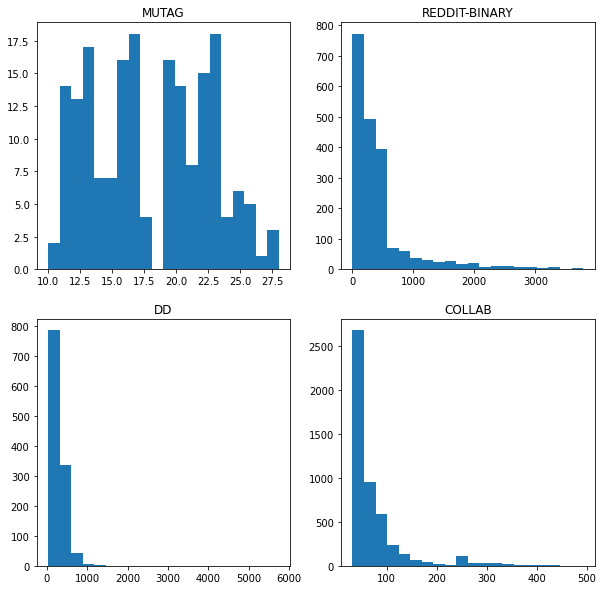

In [248]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2,2, figsize=(10,10))

ax = axes.ravel()
for i, name in enumerate(["MUTAG", "REDDIT-BINARY", "DD", "COLLAB"]):
    print(name)
    dataset = TUDataset(root='data/TUDataset', name=name)
    torch.manual_seed(12345)
    print("num dataset : " + str(len(dataset)))
    print("num class : " + str(dataset.num_classes))
    max_nodes = 0
    nodes = [d.num_nodes for d in dataset]
    print("max nodes : " + str(max(nodes)))
    print("average nodes : " + str(np.average(nodes)))
    print("std nodes : " + str(np.std(nodes)))
    ax[i].hist(nodes, bins=20, label=name)
    ax[i].set_title(name)
    print("="*20)

plt.savefig("benchmark_nodes_hist.png", dpi=200)

492